# `CheMeleon` Foundation Finetuning

This notebook demonstrates how to use the `CheMeleon` foundation model with ChemProp to achieve accurate prediction on small datasets.
One can also use this functionality from the Command Line Interface by using `--from-foundation chemeleon`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jacksonburns/chemeleon/blob/main/examples/finetuning_demo.ipynb)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install rdkit
!pip install chemprop
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.2/825.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 108.7 MB/s eta 0:00:00


In [ ]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

Cloning into 'chemprop'...
remote: Enumerating objects: 25449, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 25449 (delta 108), reused 44 (delta 43), pack-reused 25245 (from 3)
Receiving objects: 100% (25449/25449), 873.27 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (18244/18244), done.
Updating files: 100% (337/337), done.
/content/chemprop
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━

## Retrieving the `CheMeleon` Model

The `CheMeleon` model file is stored on Zenodo at [this link](https://zenodo.org/records/15460715).
Please cite the Zenodo if you use this model in published work.
You can manually download for your own use, or simply execute the below cell to programatically download it using Python:

In [ ]:
from urllib.request import urlretrieve

urlretrieve(
    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
    "chemeleon_mp.pt",
)

('chemeleon_mp.pt', <http.client.HTTPMessage at 0x7ac508062000>)

## Initializing `CheMeleon`

`CheMeleon` uses the following classes for featurization, message passing, and aggregation:

In [1]:
import torch

from chemprop import featurizers, nn

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
agg = nn.MeanAggregation()
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])

<All keys matched successfully>

In [2]:
def convert_to_float(value):

    """
    This function converts a string to float. It handles strings with > or < , common in biological IC50 values.

    Args:
        value (str or float): a string or a float

    returns:
        value (float): the float version of the string, or just the value if it was already a float
    """

    if isinstance(value, float):
        return value
    elif isinstance(value, str):
        if value.startswith('>'):
            value_cleaned = value[1:]
        elif value.startswith('<'):
            value_cleaned = value[1:]
        else:
            value_cleaned = value
        try:
            return float(value_cleaned)
        except (ValueError, TypeError):
            print(value_cleaned)
            return None


If you have an existing ChemProp model, you can simply replace your `agg`, `featurizer`, and `mp` with these classes and you can immediately take advantage of `CheMeleon`!

## Standard ChemProp Preparation

The below code handles importing needed modules, setting up the data, and initializing the ChemProp model.
It's **mostly** the same as the `training` example provided in the ChemProp repository - for a more detailed breakdown, check that notebook.

The one important change is that we must set `input_dim=mp.output_dim` when we initialize our FFN.
This ensure that the dimension of the learned representation from `CheMeleon` matches the input size for the regressor.
Also important to note here is that to make the `CheMeleon` model useful you set up your own FFN to regress the target you care about - in this case lipophilicity.

In [3]:
def get_ligands_dict(row):

    """
    Counts occurrences of strings in the L1, L2 and L3 columns in a row and creates a dictionary

    Args:
        row: a row of a dataframe

    returns:
        string_count (dict): a dictionnary containing the SMILES of the L1, L2 and L3 columns with their count of appearance
    """

    string_count = {}
    for col in ['L1', 'L2', 'L3']:
        string = row[col]
        if string in string_count:
            string_count[string] += 1
        else:
            string_count[string] = 1
    return string_count

def prepare_df(df_original):

    """
    This function takes a dataframe (formated like our original dataset of ruthenium complexes).
    It performs all necessary processing to make it usable in the code, including :
                 - canonicalising the SMILES
                 - creating the MOL columns with the RDKit mol representations
                 - creating a dictionnary and a set of the ligands SMILES (necessary for later functions)
                 - creating a set of the RDKit mol representations
                 - standardize the complexes with 2 identical ligands to AAB representation
                 - calculates the Morgan fingerprints and adding them in a Fingerprint column
                 - renames the columns
                 - associates an ID to each complex (necessary for indicing functions)
                 - calculates the pIC50 drom the IC50 column

    Args:
        df: the dataframe

    returns:
        df: the processed dataframe with Morgan Fingerprints
    """

    df = df_original.copy()

    df.dropna(subset=['L1', 'L2', 'L3'], how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)

    df = canonical_smiles(df, 'L1')
    df = canonical_smiles(df, 'L2')
    df = canonical_smiles(df, 'L3')

    df['Ligands_Dict'] = df.apply(get_ligands_dict, axis=1)
    df['Ligands_Set'] = df.apply(lambda row: set([row['L1'], row['L2'], row['L3']]), axis=1)
    #df['Mols_Set'] = df.apply(lambda row: set([row['MOL1'], row['MOL2'], row['MOL3']]), axis=1)

    #AAB standardization
    df = swap_identical_ligands(df)

    df.rename(columns={'IC50 (μM)': 'IC50', 'Incubation Time (hours)': 'IncubationTime', 'Partition Coef logP': 'logP', 'Cell Lines ': 'Cells'}, inplace=True)
    #add_lists = lambda row: [sum(x) for x in zip(row['ECFP4_1'], row['ECFP4_2'], row['ECFP4_3'])]
    #df['Fingerprint'] = df.apply(add_lists, axis=1)

    #df['ID']=[i for i in range(len(df))]

    df['IC50'] = df['IC50'].apply(convert_to_float)
    df['pIC50'] = df['IC50'].apply(lambda x: - np.log10(x * 10 ** (-6)))

    return df

def average_duplicates(df, column_todrop, column_values):

    """
    This function takes a dataframe as input. If there is duplicates in the 'column_todrop' column with various values
    in the 'column_values' column, it allows to keep only one row with the 'column_todrop' item, and the corresponding
    value in the 'column_values' column is an average of all previous the duplicates of the 'column_todrop'.

    Args:
        df: the dataframe
        column_to_drop (str): the name of the column where duplicates have to be dropped
        column_values (str): the name of the column containing the values we want to keep an average of

    returns:
        df: the filtered dataframe
    """

    df[column_todrop+'_dup'] = df[column_todrop]
    df[column_todrop+'_dup'] = df[column_todrop+'_dup'].apply(tuple)
    df[column_values] = df.groupby(column_todrop+'_dup')[column_values].transform('mean')
    df = df.groupby(column_todrop+'_dup', as_index=False).first()
    df.drop(columns=[column_todrop+'_dup'])
    df.reset_index(inplace=True)
    print(f'Length of training dataset after cleaning duplicates, before adding permutations : {len(df)}')
    return df

def has_two_identical_ligands(l_dict):

    """
    Takes a dictionnary of strings. If one of the strings as an occurence of 2, it return True.

    Args:
        l_dict : dictionnary

    returns:
        result(bool)
    """

    result = []
    for d in l_dict:
        if any(count == 2 for count in d.values()):
            result.append(True)
        else:
            result.append(False)
    return result


def swap_identical_ligands(df):

    """
    Converts the metals complexes with 2 identical ligands to the AAB structure.

    Args:
        df : dataframe containing at least a column 'Ligands_Dict' of dicts, and 3 columns L1, L2 and L3 of strings

    returns:
       df: updated dataframe
    """

    dict_list = df['Ligands_Dict']
    results = has_two_identical_ligands(dict_list)
    for i, result in enumerate(results):
        if result:
            ligand_dict = dict_list[i]
            twice_ligand = None
            once_ligand = None
            for ligand, count in ligand_dict.items():
                if count == 2:
                    twice_ligand = ligand
                elif count == 1:
                    once_ligand = ligand
            df.at[i, 'L1'] = twice_ligand
            df.at[i, 'L2'] = twice_ligand
            df.at[i, 'L3'] = once_ligand
    return df

def canonical_smiles(df, smiles):

    """
    Checks if the column exists, and then canonicalizes the SMILES of the column.

    Args:
        df (pandas dataframe): dataframe
        smiles (str): the name of the column containing the SMILES to be canonicalized

    returns:
        df : the dataframe with canonicalized SMILES
    """

    if smiles not in df.columns:
        print(f"Column {smiles} not found in DataFrame.")
        return

    df[smiles] = df[smiles].apply(lambda x: Chem.MolFromSmiles(x))
    df[smiles] = df[smiles].apply(lambda x: Chem.MolToSmiles(x))

    return df

In [5]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback

class LossHistory(pl.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = []   # initialize here 

    def on_train_epoch_end(self, trainer, pl_module):
        # Extract losses if available
        train_loss = trainer.callback_metrics.get("train_loss")
        val_loss = trainer.callback_metrics.get("val_loss")

        entry = {
            "epoch": trainer.current_epoch,
            "train_loss": float(train_loss) if train_loss is not None else None,
            "val_loss": float(val_loss) if val_loss is not None else None,
        }
        self.history.append(entry)

loss_history = LossHistory()

In [ ]:
import os

os.getcwd()
os.listdir()

['.config',
 'ruthenium_complexes_dataset.csv',
 'chemeleon_mp.pt',
 'sample_data']

In [ ]:
from google.colab import files
uploaded = files.upload()

In [6]:
from pathlib import Path

from lightning import pytorch as pl

from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

import torch.nn as torch_nn

from chemprop import data, models

import time

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

pl._logger.setLevel("ERROR")  # suppress INFO and WARNING, only show ERROR+

chemprop_dir = Path.cwd().parent
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'SMILES' # name of the column containing SMILES strings
target_columns = ['pIC50'] # list of names of the columns containing targets
df_input = pd.read_csv("./ruthenium_complexes_dataset.csv")

df_input = prepare_df(df_input)
df_input = average_duplicates(df_input,'Ligands_Dict', 'pIC50')


#df_input = df_input.sample(n=50)

df_input.reset_index(drop=True, inplace=True)

df_input['SMILES'] = df_input.L1 + '.' + df_input.L2 + '.' + df_input.L3
df_input['ID'] = df_input.index

loss_fn = torch_nn.L1Loss()

smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
#train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
#train_data, val_data, test_data = data.split_data_by_indices(
#    all_data, train_indices, val_indices, test_indices
#)


Length of training dataset after cleaning duplicates, before adding permutations : 718


Now we can take a look at the model, which we can see has the huge message passing setup from `CheMeleon`:

## Training

The remainder of this notebook again follows the typical training routine.
With the addition of `CheMeleon` your model may take longer to train but will (hopefully!) have better performance, particularly if the dataset you have is small!

In [7]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)

#trainer = pl.Trainer(
#    logger=False,
#    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
#    enable_progress_bar=True,
#    accelerator="gpu",
#    devices=1,
#    max_epochs=10, # number of epochs to train for
#    callbacks=[checkpointing, loss_history], # Use the configured checkpoint callback
#)

In [8]:
import random

def get_indices_chemeleon_new(df, CV, sizes=(0.8, 0.1 ,0.1), seeder=0):

    ID = list(set(df.ID)) # We extract the unique IDs for each unique complex / each permutation group
    k = 1 # This counts the cross-validation iteration, allowing to displace the sample used for test set at each iteration
    random.seed(seeder)
    random.shuffle(ID) # Randomly shuffle unique DOIs
    train_size = sizes[0] * len(ID)
    val_size = sizes[1] * len(ID)
    test_size = sizes[2] * len(ID)
    train_val_size = val_size + train_size

    train_CV = []
    val_CV = []

    test_CV = np.array_split(ID, round(1/sizes[2]))
    test_CV = [s.tolist() for s in test_CV]

    for i in range(CV):

        train_val = [v for v in ID if v not in test_CV[i]]
        random.shuffle(train_val)

        train = train_val[0:round((train_size/train_val_size)*len(train_val))]
        val = train_val[round((train_size/train_val_size)*len(train_val)):len(train_val)]

        train_CV.append(train)
        val_CV.append(val)

        print(f'train length : {len(train)} | val length : {len(val)} | test length : {len(test_CV[i])}')

    return(train_CV, val_CV, test_CV)



In [9]:
import random
from random import seed

def get_indices_chemeleon(df, CV, sizes=(0.8, 0.1 ,0.1), seeder=0):
    indices_final = []
    ID = list(set(df.ID)) # We extract the unique IDs for each unique complex / each permutation group
    k = 1 # This counts the cross-validation iteration, allowing to displace the sample used for test set at each iteration
    random.seed(seeder)
    random.shuffle(ID) # Randomly shuffle unique DOIs
    train_range = sizes[0] * len(ID)
    val_range = sizes[1] * len(ID)
    test_range = sizes[2] * len(ID)
    train_val_range = val_range + train_range

    for seed in range(CV):

        # Split
        train, val, test = [], [], []
        train_val = []

        for i in range(round((k-1) * test_range)):
            selected = df[df['ID'] == ID[i]] # We choose a DOI at random and select all permutations of the all complexes with this DOI
            indices = selected.index.tolist() # The indices of these entries are added to the training set
            for j in indices:
                train_val.append(j)

        for i in range(round((k-1) * test_range), round(k * test_range)):
            # This k-dependent interval ensures we go over the whole dataset : at each iteration we take the next 10% of the DOI list, in the end we go
            # through the whole DOI list, hence through the whole dataset.

            selected = df[df['ID'] == ID[i]] # We choose a DOI at random and select all permutations of the all complexes with this DOI
            indices = selected.index.tolist() # The indices of these entries are added to the test set
            for j in indices:
                test.append(j)

        for i in range(round(k * test_range), len(ID)):
            selected = df[df['ID'] == ID[i]]
            indices = selected.index.tolist()
            for j in indices:
                train_val.append(j)

        random.shuffle(train_val)

        train = train_val[0:round((train_range/train_val_range)*len(train_val))]
        val = train_val[round((train_range/train_val_range)*len(train_val)):len(train_val)]

        print(f'train length : {len(train)} | val length : {len(val)} | test length : {len(test)}')

        indices_final.append(([train],[val],[test]))

        k+=1

    return(indices_final)

In [54]:
def obtain_metrics(y_data, y_predictions):

    """
    Takes the real and predicted values and returns the metrics associated, to get an evaluation
    of the model. The metrics chosen here are MAE, RMSE, Ratio and R² Score.

    Args:
        y_data (array): an array containging the real target values of the dataset
        y_predictions (array): an array containging the predicted (by the model) target values of the dataset

    returns:
        str: a little text displaying the metrics values
    """

    mae = mean_absolute_error(y_data, y_predictions)
    mse = mean_squared_error(y_data, y_predictions)
    rmse = float(np.sqrt(mse))
    ratio = float(rmse/mae)
    r2 = r2_score(y_data, y_predictions)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'Ratio': ratio,
        'R² Score': r2
    }

In [11]:
import matplotlib.pyplot as plt

def plot_cv_results(y_data, y_predictions, log=False):
    """
    This function plots the correlation between the real and predicted values of either the target data (IC50), or the
    pvalue of the target data (pIC50).
    It also prints the residual errors in a second plot frame.

    Args:
        y_data (array): an array containging the real target values of the dataset
        y_predictions (array): an array containging the predicted (by the model) target values of the dataset
        log (bool): set to True if we want the pIC50 instead of the IC50

    returns:
        two plots
    """

    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

    PredictionErrorDisplay.from_predictions(
        y_true=y_predictions,
        y_pred=y_data,
        # We exchange data and predictions to get the true values as the abscissa and predictions as ordinate
        kind="actual_vs_predicted",
        scatter_kwargs={"alpha": 0.5},
        ax=axs[0],
    )
    axs[0].axis("square")
    if log:
        axs[0].set_xlabel("True pIC50", fontsize=16)
        axs[0].set_ylabel("Predicted pIC50", fontsize=16)
    else:
        axs[0].set_xlabel("True IC50 (μM)", fontsize=16)
        axs[0].set_ylabel("Predicted IC50 (μM)", fontsize=16)

    max_value = int(np.max(np.concatenate((y_data, y_predictions))))
    min_value = max(0, int(np.min(np.concatenate((y_data, y_predictions)))))
    x_ticks = [i for i in range(min_value, max_value + 1, 100)] + [max_value]
    y_ticks = [i for i in range(min_value, max_value + 1, 100)] + [max_value]
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[0].tick_params(axis='both', which='major', labelsize=16)

    PredictionErrorDisplay.from_predictions(
        y_true=y_predictions,
        y_pred=y_data,
        # Same here (cf previous comment)
        kind="residual_vs_predicted",
        scatter_kwargs={"alpha": 0.5},
        ax=axs[1],
    )
    axs[1].axis("square")

    if log:
        axs[1].set_xlabel("True pIC50", fontsize=16)
        axs[1].set_ylabel("Residuals (predicted pIC50 - true pIC50)", fontsize=16)
    else:
        axs[1].set_xlabel("True IC50 (μM)", fontsize=16)
        axs[1].set_ylabel("Residuals (predicted IC50 - true IC50) (μM)", fontsize=16)

    axs[1].tick_params(axis='both', which='major', labelsize=16)

    plt.subplots_adjust(wspace=0.4)  # Adjust horizontal space between plots

    _ = fig.suptitle(
        "Regression displaying correlation between true and predicted data", y=0.9
    )
    #plt.savefig("./figures/figure.png", dpi=300, transparent=True)

    plt.show()

In [12]:
def cross_validation_chemeleon_new(all_data, indices, num_workers=0):
    y_data= []
    y_predictions = []

    all_metrics = []

    all_loss_histories = []  # collect across folds

    train_CV, val_CV, test_CV = indices

    start_time = time.time()

    for i in range(len(train_CV)):
        print("CV iteration", i)

        loss_history = LossHistory()

        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        agg = nn.MeanAggregation()
        chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
        mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
        mp.load_state_dict(chemeleon_mp['state_dict'])

        train_indices, val_indices, test_indices = [train_CV[i]], [val_CV[i]], [test_CV[i]]  # unpack the tuple into three separate lists
        train_data, val_data, test_data = data.split_data_by_indices(
          all_data, train_indices, val_indices, test_indices
        )
        train_dset = data.MoleculeDataset(train_data[0], featurizer)
        scaler = train_dset.normalize_targets()
        val_dset = data.MoleculeDataset(val_data[0], featurizer)
        val_dset.normalize_targets(scaler)
        test_dset = data.MoleculeDataset(test_data[0], featurizer)
        #test_dset.normalize_targets(scaler) this dramatically lowers R2
        train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
        val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
        test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
        ffn = nn.RegressionFFN(output_transform=output_transform, input_dim=mp.output_dim, n_layers=2)
        metric_list = [nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()]
        mpnn = models.MPNN(mp, agg, ffn, batch_norm=False, metrics=metric_list)

        trainer = pl.Trainer(
        logger=False,               # disable TensorBoard/W&B logging
        enable_model_summary=False, # disables model architecture printout
        enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=True,
        log_every_n_steps=0,
        accelerator="gpu",
        devices=1,
        max_epochs=20, # number of epochs to train for
        callbacks=[checkpointing, loss_history], # Use the configured checkpoint callback
        )

        trainer.fit(mpnn, train_loader, val_loader)   # Fit model to data

        # Ploting loss curve for each CV iteration

        df_losses = pd.DataFrame(loss_history.history)
        df_losses["fold"] = i
        all_loss_histories.append(df_losses)

        fold_df = df_losses.sort_values("epoch")

        plt.figure()

        plt.plot(fold_df["epoch"], fold_df["train_loss"], label="train", color="blue")
        plt.plot(fold_df["epoch"], fold_df["val_loss"], linestyle="--", label="val", color="orange")

        plt.title(f"Fold {i}")
        plt.ylabel("Loss")
        plt.legend()

        plt.xlabel("Epoch")
        plt.tight_layout()
        plt.show()

        ###

        test_preds = trainer.predict(mpnn, test_loader)
        test_preds = torch.cat([tensor for tensor in test_preds]) # Predict values

        for i in range(len(test_preds)):
            y_predictions.append(float(test_preds[i][0]))
            y_data.append(test_data[0][i].y[0]) # Update lists

        results = trainer.test(dataloaders=test_loader)
        all_metrics.append(results)

    end_time = time.time()

    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    y_data = np.array(y_data)
    y_predictions = np.array(y_predictions)

    metrics = obtain_metrics(y_data, y_predictions)
    print(metrics)

    return y_data, y_predictions



In [13]:
def cross_validation_chemeleon(all_data, indices, num_workers=0):

    y_data= []
    y_predictions = []

    all_metrics = []
    start_time = time.time()
    for i in range(len(indices)):
        print("CV iteration", i)

        train_indices, val_indices, test_indices = indices[i]  # unpack the tuple into three separate lists
        train_data, val_data, test_data = data.split_data_by_indices(
          all_data, train_indices, val_indices, test_indices
        )
        train_dset = data.MoleculeDataset(train_data[0], featurizer)
        scaler = train_dset.normalize_targets()
        val_dset = data.MoleculeDataset(val_data[0], featurizer)
        val_dset.normalize_targets(scaler)
        test_dset = data.MoleculeDataset(test_data[0], featurizer)
        test_dset.normalize_targets(scaler)
        train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
        val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
        test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
        ffn = nn.RegressionFFN(output_transform=output_transform, input_dim=mp.output_dim, n_layers=2)
        metric_list = [nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()]
        mpnn = models.MPNN(mp, agg, ffn, batch_norm=False, metrics=metric_list)

        trainer = pl.Trainer(
        logger=False,               # disable TensorBoard/W&B logging
        enable_model_summary=False, # disables model architecture printout
        enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
        enable_progress_bar=True,
        log_every_n_steps=0,
        accelerator="gpu",
        devices=1,
        max_epochs=20, # number of epochs to train for
        callbacks=[checkpointing, loss_history], # Use the configured checkpoint callback
        )

        trainer.fit(mpnn, train_loader, val_loader)   # Fit model to data
        test_preds = trainer.predict(mpnn, test_loader)
        test_preds = torch.cat([tensor for tensor in test_preds]) # Predict values
        for i in range(len(test_preds)):
            y_predictions.append(float(test_preds[i][0]))
            y_data.append(test_data[0][i].y[0]) # Update lists

        results = trainer.test(dataloaders=test_loader)
        all_metrics.append(results)

    end_time = time.time()

    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    y_data = np.array(y_data)
    y_predictions = np.array(y_predictions)

    r2s=0
    for i in range(len(all_metrics)):
        r2s = r2s + all_metrics[i][0]['test/r2']

    r2s = r2s/(len(all_metrics))

    print(f'Mean of R2 scores calculated for each fold : {r2s}')


    metrics = obtain_metrics(y_data, y_predictions)
    print(metrics)
    return y_data, y_predictions

In [ ]:
indices = get_indices_chemeleon_new(df_input, 10)

train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 574 | val lenght : 72 | test length : 72
train length : 575 | val lenght : 72 | test length : 71
train length : 575 | val lenght : 72 | test length : 71


CV iteration 0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

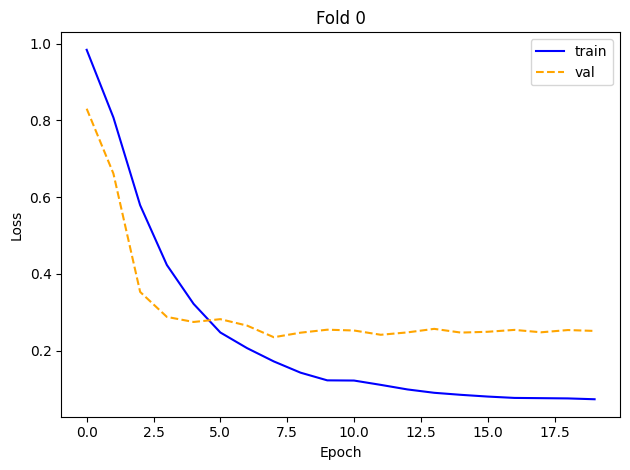

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3181023895740509     │
│          test/r2          │    0.6557337045669556     │
│         test/rmse         │     0.474892795085907     │
└───────────────────────────┴───────────────────────────┘

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

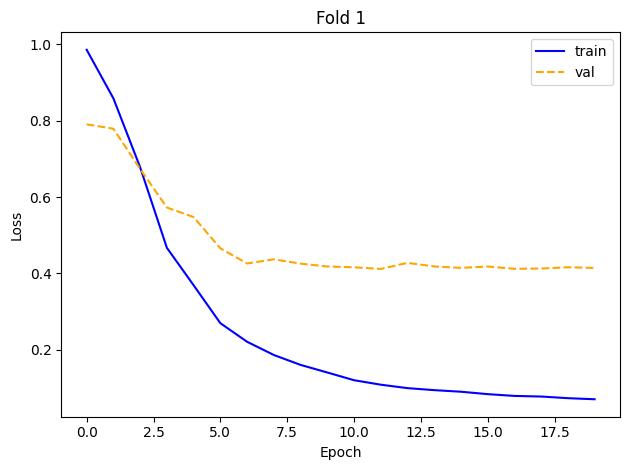

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.24699494242668152    │
│          test/r2          │    0.8516757488250732     │
│         test/rmse         │    0.34700483083724976    │
└───────────────────────────┴───────────────────────────┘

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

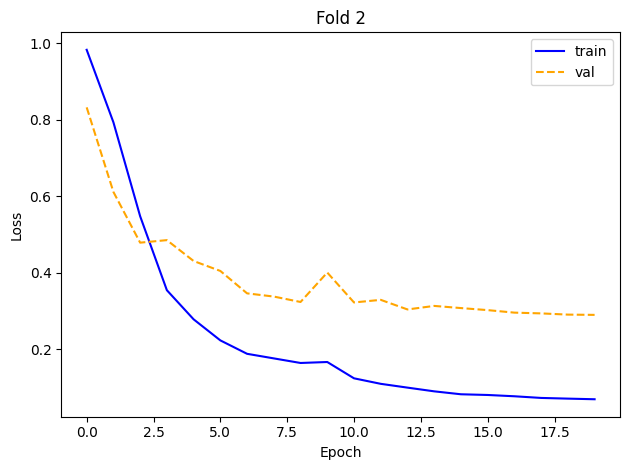

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.21537944674491882    │
│          test/r2          │    0.8494693040847778     │
│         test/rmse         │    0.28465965390205383    │
└───────────────────────────┴───────────────────────────┘

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

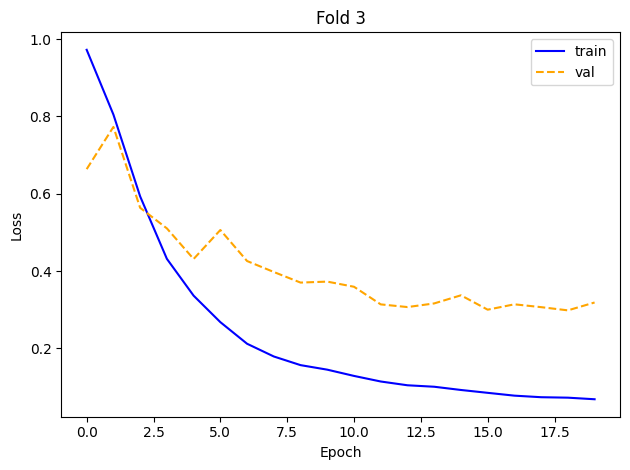

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.24132877588272095    │
│          test/r2          │    0.8123829960823059     │
│         test/rmse         │    0.3203260600566864     │
└───────────────────────────┴───────────────────────────┘

CV iteration 4


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

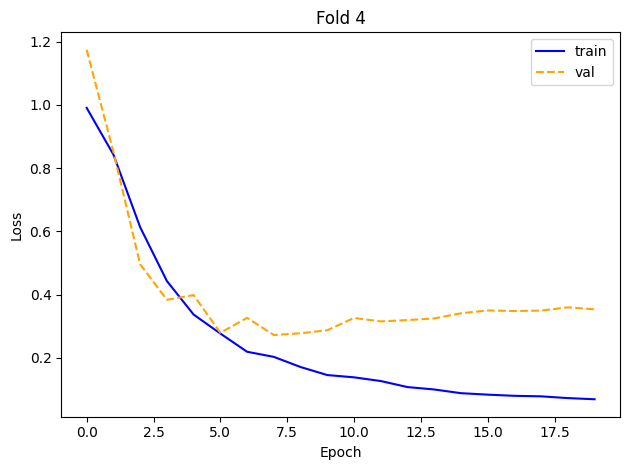

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.25722941756248474    │
│          test/r2          │    0.8833099603652954     │
│         test/rmse         │    0.3249715566635132     │
└───────────────────────────┴───────────────────────────┘

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

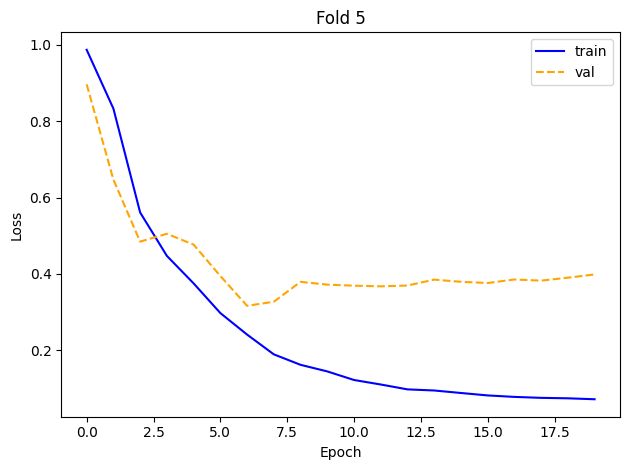

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.22934108972549438    │
│          test/r2          │    0.8681839108467102     │
│         test/rmse         │    0.3089786171913147     │
└───────────────────────────┴───────────────────────────┘

CV iteration 6


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

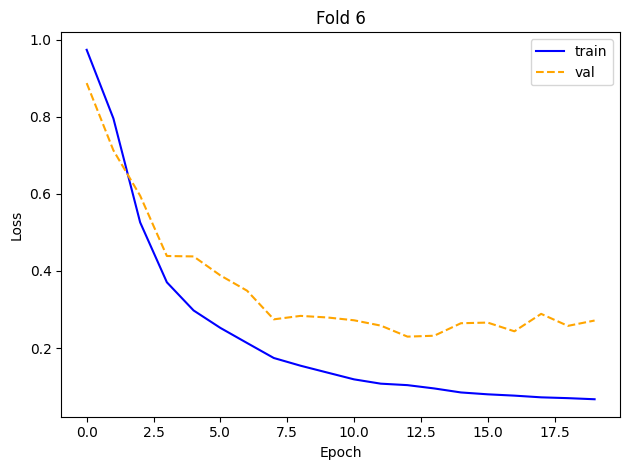

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.3166160583496094     │
│          test/r2          │    0.7402968406677246     │
│         test/rmse         │    0.4087923467159271     │
└───────────────────────────┴───────────────────────────┘

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

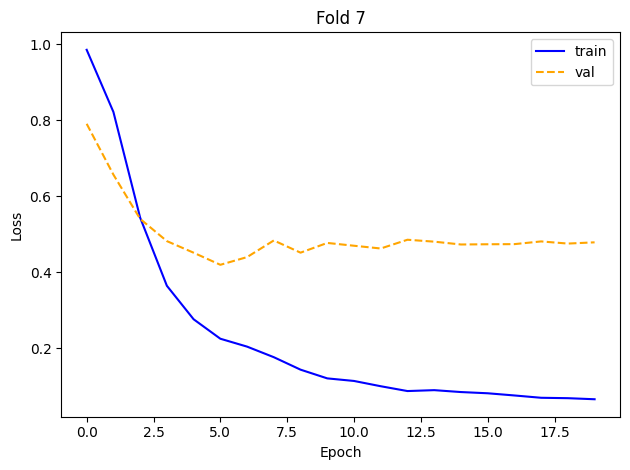

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.19416575133800507    │
│          test/r2          │    0.9017120599746704     │
│         test/rmse         │    0.2648232877254486     │
└───────────────────────────┴───────────────────────────┘

CV iteration 8


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

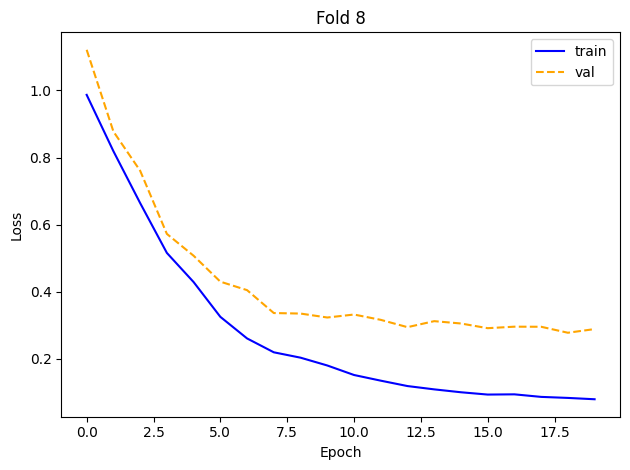

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.1957547515630722     │
│          test/r2          │    0.8682960867881775     │
│         test/rmse         │    0.2981090247631073     │
└───────────────────────────┴───────────────────────────┘

CV iteration 9


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

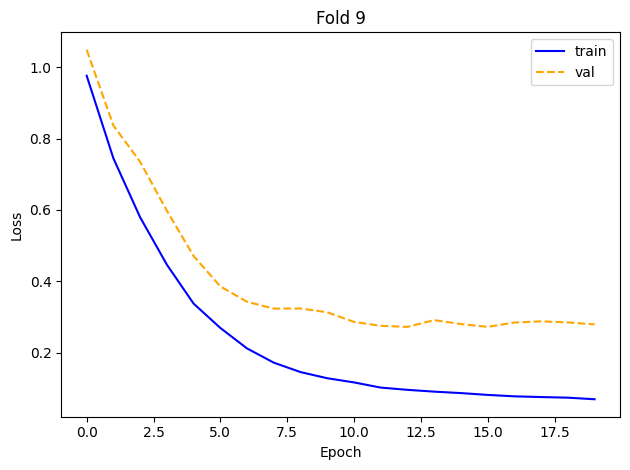

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.2503366768360138     │
│          test/r2          │    0.8273158669471741     │
│         test/rmse         │    0.35271722078323364    │
└───────────────────────────┴───────────────────────────┘

Total training time: 868.40 seconds (14.47 minutes)
{'MAE': 0.3376566648700744, 'RMSE': np.float64(0.4892822000388539), 'Ratio': np.float64(1.449052398320415), 'R² Score': 0.6558744024281702}


In [ ]:
y_data, y_predictions = cross_validation_chemeleon_new(all_data, indices)

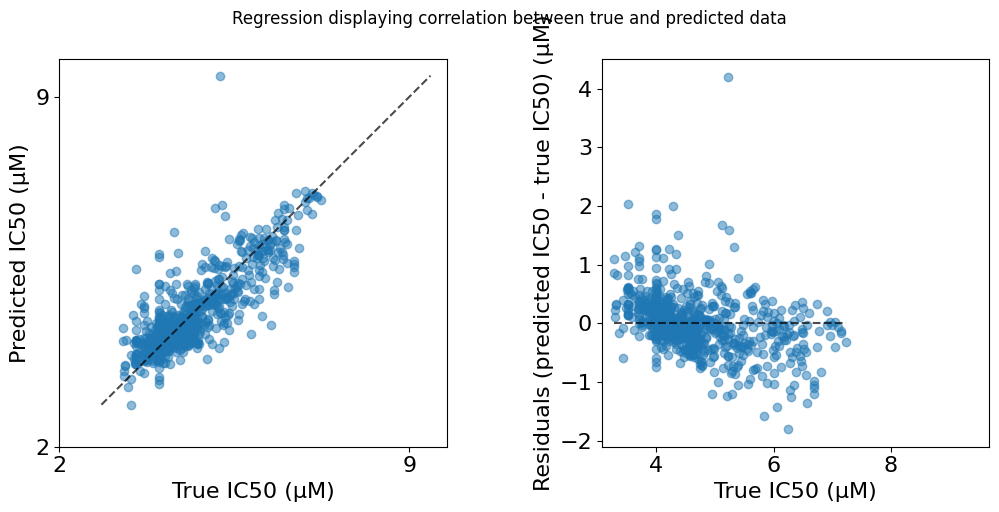

In [ ]:
plot_cv_results(y_data, y_predictions)

In [ ]:
#torch.save(mpnn.state_dict(), "finetuned_weights.pth")

In [14]:
import random

def get_indices_chemeleon_DOI(df, CV, sizes=(0.8, 0.1 ,0.1), seeder=0):

    DOI = list(set(df.DOI)) # We extract the unique DOIs for each unique complex / each permutation group
    k = 1 # This counts the cross-validation iteration, allowing to displace the sample used for test set at each iteration
    random.seed(seeder)
    random.shuffle(DOI) # Randomly shuffle unique DOIs
    train_size = sizes[0] * len(DOI)
    val_size = sizes[1] * len(DOI)
    test_size = sizes[2] * len(DOI)
    train_val_size = val_size + train_size

    train_CV = []
    val_CV = []

    test_CV = []

    DOI_test = np.array_split(DOI, round(1/sizes[2]))

    for i in range(len(DOI_test)):
        selected = df[df["DOI"].isin(DOI_test[i])].copy()
        test_CV.append(selected.index.tolist())

    for i in range(CV):

        DOI_train_val = []
        DOI_train = []
        DOI_val = []

        DOI_train_val = [d for d in DOI if d not in DOI_test[i]]
        random.shuffle(DOI_train_val)

        DOI_train = DOI_train_val[0:round((train_size/train_val_size)*len(DOI_train_val))]
        DOI_val = DOI_train_val[round((train_size/train_val_size)*len(DOI_train_val)):len(DOI_train_val)]

        train = (df[df["DOI"].isin(DOI_train)].copy()).index.tolist()
        val = (df[df["DOI"].isin(DOI_val)].copy()).index.tolist()

        train_CV.append(train)
        val_CV.append(val)

        print(f'train length : {len(train)} | val length : {len(val)} | test length : {len(test_CV[i])}')

    return(train_CV, val_CV, test_CV)



In [ ]:
indices_DOI = get_indices_chemeleon_DOI(df_input, 10)

train length : 587 | val lenght : 60 | test length : 71
train length : 583 | val lenght : 66 | test length : 69
train length : 555 | val lenght : 82 | test length : 81
train length : 598 | val lenght : 66 | test length : 54
train length : 550 | val lenght : 82 | test length : 86
train length : 577 | val lenght : 64 | test length : 77
train length : 576 | val lenght : 66 | test length : 76
train length : 564 | val lenght : 74 | test length : 80
train length : 573 | val lenght : 76 | test length : 69
train length : 576 | val lenght : 87 | test length : 55


CV iteration 0


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

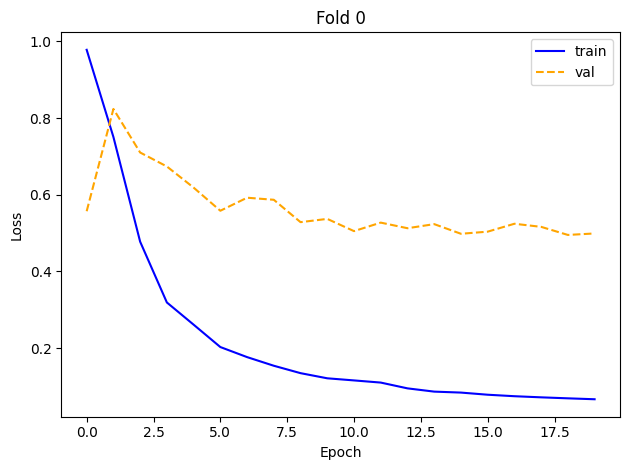

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.21360962092876434    │
│          test/r2          │     0.671962559223175     │
│         test/rmse         │    0.3151213228702545     │
└───────────────────────────┴───────────────────────────┘

CV iteration 1


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

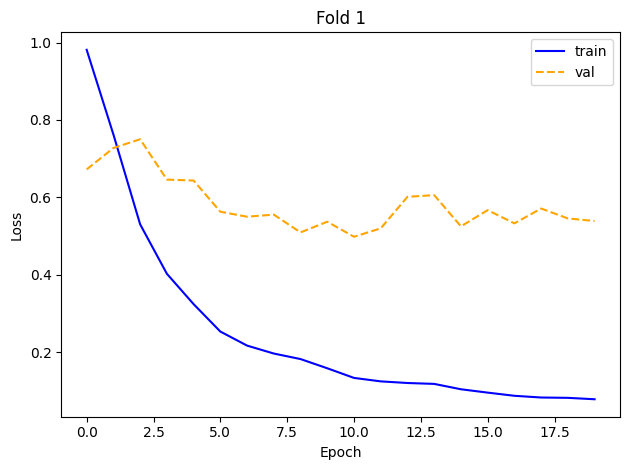

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.22229184210300446    │
│          test/r2          │    0.8602104187011719     │
│         test/rmse         │    0.2984694838523865     │
└───────────────────────────┴───────────────────────────┘

CV iteration 2


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

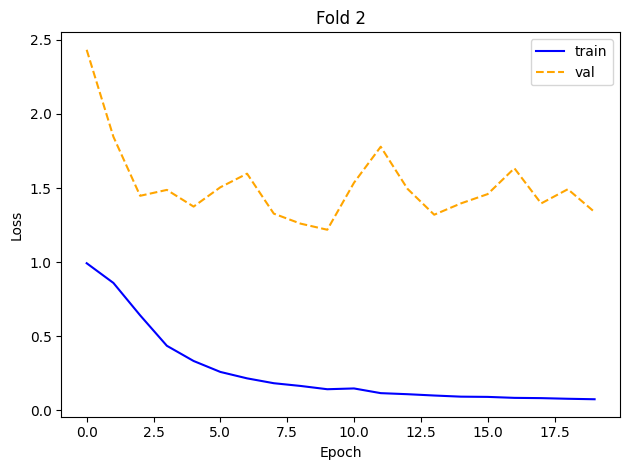

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.20760726928710938    │
│          test/r2          │    0.7532063126564026     │
│         test/rmse         │    0.2756880521774292     │
└───────────────────────────┴───────────────────────────┘

CV iteration 3


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

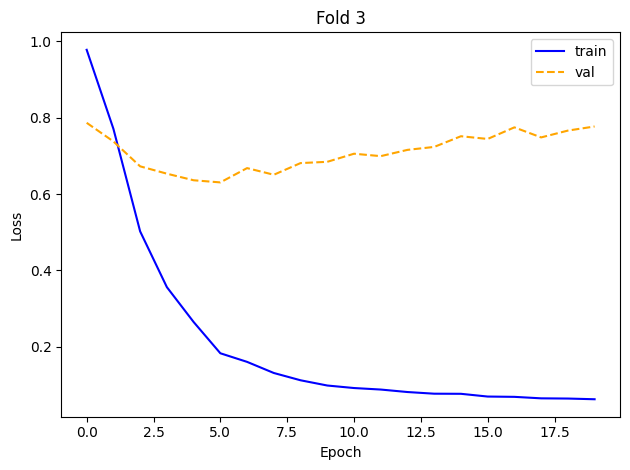

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.17493152618408203    │
│          test/r2          │    0.7552968859672546     │
│         test/rmse         │    0.22379261255264282    │
└───────────────────────────┴───────────────────────────┘

CV iteration 4


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

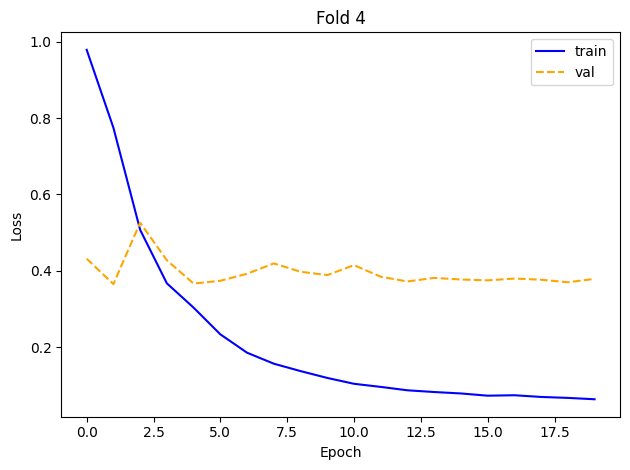

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.18263433873653412    │
│          test/r2          │    0.8833165764808655     │
│         test/rmse         │    0.25568321347236633    │
└───────────────────────────┴───────────────────────────┘

CV iteration 5


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

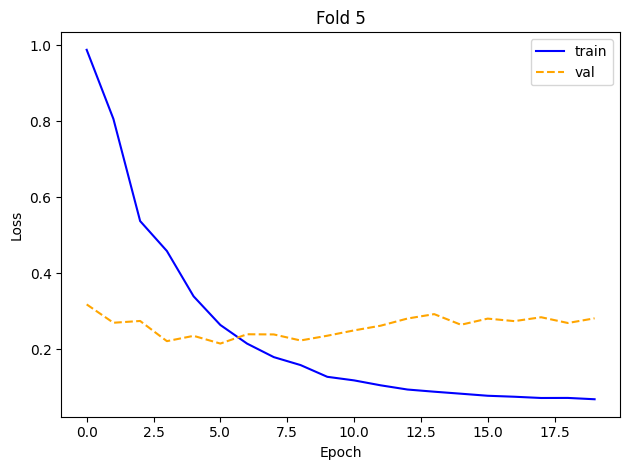

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6175089478492737     │
│          test/r2          │    0.12384998798370361    │
│         test/rmse         │    0.7850273847579956     │
└───────────────────────────┴───────────────────────────┘

CV iteration 6


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

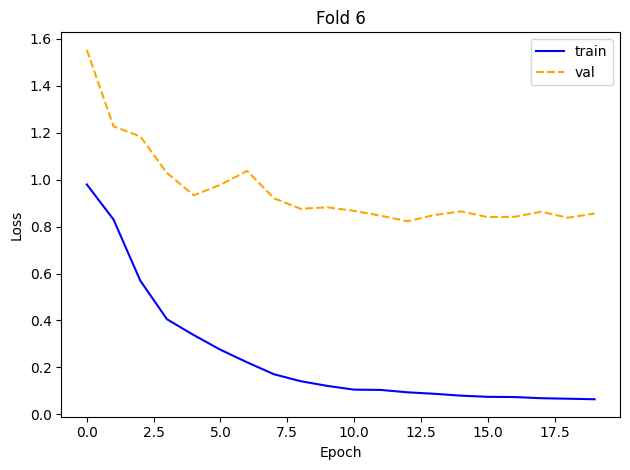

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.25451982021331787    │
│          test/r2          │    0.9155738949775696     │
│         test/rmse         │    0.31781235337257385    │
└───────────────────────────┴───────────────────────────┘

CV iteration 7


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:701: Checkpoint directory /content/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
y_data_DOI, y_predictions_DOI = cross_validation_chemeleon_new(all_data, indices_DOI)

In [ ]:
plot_cv_results(y_data_DOI, y_predictions_DOI)

In [49]:
import random
from collections import defaultdict
from tqdm import tqdm
from rdkit.Chem.Scaffolds import MurckoScaffold



def get_indices_chemeleon_scaff(df, CV, sizes=(0.8, 0.1, 0.1), seeder=0):

    scaff_dict = scaffold_to_smiles(mols, use_indices=True) # We extract the scaffolds and the indices of the complexes having each scaffold
    scaffolds = list(scaff_dict.keys()) # Define a list of the possible scaffolds
    k = 1 # Iteration count
    random.seed(seeder)
    random.shuffle(scaffolds) # Randomly shuffle scaffolds
    train_size = sizes[0] * len(scaffolds)
    val_size = sizes[1] * len(scaffolds)
    test_size = sizes[2] * len(scaffolds)
    train_val_size = val_size + train_size

    train_CV = []
    val_CV = []

    test_CV = []

    scaff_test = np.array_split(scaffolds, round(1/sizes[2]))

    for i in range(len(scaff_test)):
        indices = []
        for scaff in scaff_test[i]:
            indices = indices + list(scaff_dict[scaff])
        test_CV.append(indices)

    for i in range(CV):

        scaff_train_val = []
        scaff_train = []
        scaff_val = []

        train = []
        val = []

        scaff_train_val = [s for s in scaffolds if s not in scaff_test[i]]
        random.shuffle(scaff_train_val)

        scaff_train = scaff_train_val[0:round((train_size/train_val_size)*len(scaff_train_val))]
        scaff_val = scaff_train_val[round((train_size/train_val_size)*len(scaff_train_val)):len(scaff_train_val)]

        for scaff in scaff_train :
                train = train + list(scaff_dict[scaff])

        for scaff in scaff_val:
                val = val + list(scaff_dict[scaff])

        train_CV.append(train)
        val_CV.append(val)

        print(f'train length : {len(train)} | val length : {len(val)} | test length : {len(test_CV[i])}')

    return(train_CV, val_CV, test_CV)



In [50]:
def generate_scaffold(mol, include_chirality=False):
    """
    Computes the Bemis-Murcko scaffold for a SMILES string.

    Args:
        mol (RDkit mol): A SMILES string or an RDKit molecule.
        include_chirality (bool): Whether to include chirality.

    returns:
        scaffold (RDKit mol)
    """
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold


def scaffold_to_smiles(mols,
                       use_indices=False):
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of SMILES.

    Args:
        mols (list): A list of SMILES strings or RDKit molecules.
        use_indices (bool): Whether to map to the SMILES' index in all_smiles rather than mapping
        to the SMILES string itself. This is necessary if there are duplicate SMILES. Default is False

    returns:
        scaffolds (dict): A dictionary mapping each unique scaffold to all SMILES (or SMILES indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in tqdm(enumerate(mols), total=len(mols)):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)

    return scaffolds

def has_two_identical_ligands(l_dict):

    """
    Takes a dictionnary of strings. If one of the strings as an occurence of 2, it return True.

    Args:
        l_dict : dictionnary

    returns:
        result(bool)
    """

    result = []
    for d in l_dict:
        if any(count == 2 for count in d.values()):
            result.append(True)
        else:
            result.append(False)
    return result


def swap_identical_ligands(df):

    """
    Converts the metals complexes with 2 identical ligands to the AAB structure.

    Args:
        df : dataframe containing at least a column 'Ligands_Dict' of dicts, and 3 columns L1, L2 and L3 of strings

    returns:
       df: updated dataframe
    """

    dict_list = df['Ligands_Dict']
    results = has_two_identical_ligands(dict_list)
    for i, result in enumerate(results):
        if result:
            ligand_dict = dict_list[i]
            twice_ligand = None
            once_ligand = None
            for ligand, count in ligand_dict.items():
                if count == 2:
                    twice_ligand = ligand
                elif count == 1:
                    once_ligand = ligand
            df.at[i, 'L1'] = twice_ligand
            df.at[i, 'L2'] = twice_ligand
            df.at[i, 'L3'] = once_ligand
    return df



In [19]:
df_input = swap_identical_ligands(df_input)
df_input['MOL1'] = df_input['L1'].apply(Chem.MolFromSmiles)
molsA = df_input['MOL1'].tolist()


In [51]:
indices_scaff_A = get_indices_chemeleon_scaff(molsA, 10, seeder = 1)

100%|█████████████████████████████████████████████████████████████████████████████| 718/718 [00:00<00:00, 11416.92it/s]

train length : 491 | val lenght : 222 | test length : 5
train length : 695 | val lenght : 10 | test length : 13
train length : 310 | val lenght : 338 | test length : 70
train length : 693 | val lenght : 17 | test length : 8
train length : 685 | val lenght : 13 | test length : 20
train length : 609 | val lenght : 71 | test length : 38
train length : 692 | val lenght : 7 | test length : 19
train length : 379 | val lenght : 333 | test length : 6
train length : 386 | val lenght : 16 | test length : 316
train length : 486 | val lenght : 9 | test length : 223


In [ ]:
y_data_scaff_A, y_predictions_scaff_A = cross_validation_chemeleon_new(all_data, indices_scaff_A)

In [ ]:
plot_cv_results(y_data_scaff_A, y_predictions_scaff_A)

In [53]:
df_input['MOL3'] = df_input['L3'].apply(Chem.MolFromSmiles)
molsB = df_input['MOL3'].tolist()

In [ ]:
indices_scaff_B = get_indices_chemeleon_scaff(molsB, 10, seeder = 1)

In [ ]:
y_data_scaff_B, y_predictions_scaff_B = cross_validation_chemeleon_new(all_data, indices_scaff_B)

In [ ]:
plot_cv_results(y_data_scaff_B, y_predictions_scaff_B)